#Example of Tensorflow setup of a CNN

## First steps-> arranging the data


### Import libraries and load the data

First of all I've installed in colab some packages to split the dataset and also Tensorflow


In [ ]:
 
!pip install split-folders
!pip install  git+https://github.com/tensorflow/docs

Then I've imported the corresponding libraries to the notebook

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
import numpy as np
import os
import re
import keras
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing import image_dataset_from_directory

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import shutil
import os

By unzipping the file directly from our drive folder we speed up the loading and store it in the temporary server memory

In [ ]:
!unzip '/content/drive/My Drive/DIPC/Copia de Covid-X-v4.zip';

###Organising the main directories and the paths
 It is important to name the folders properly so that we can directly label them by their parent folder's name

In [ ]:

base_dir = '/content/data'
train_dir =     '/content/data/train'
validation_dir = '/content/data/validation'
train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')
train_covid_dir_old = os.path.join(train_dir, 'COVID-19') 
test_dir =       '/content/data/test'
test_normal_dir = os.path.join(test_dir, 'normal')
test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')
test_covid_dir = os.path.join(test_dir, 'COVID-19')

In [ ]:

try:
  os.mkdir(test_covid_dir)
  os.mkdir(validation_dir)
  os.mkdir(train_normal_dir)
  os.mkdir(train_pneumonia_dir)
  os.mkdir(train_covid_dir_old)
  os.mkdir(test_normal_dir)
  os.mkdir(test_pneumonia_dir)
except:
  print('Ya existen los directorios')

Now based on the txt file, we move each of the images to its corresponding folder:

In [ ]:

import shutil
f = open("/content/data/train_split.txt", "r")
for linea in f:
  try:
    shutil.move(os.path.join(train_dir,linea.split()[1]), os.path.join(train_dir,linea.split()[2],linea.split()[1]))
  except:
    print('Ya se encuentran en su carpeta')
f.close()

f = open("/content/data/test_split.txt", "r")
for linea in f:
  try:
    shutil.move(os.path.join(test_dir,linea.split()[1]), os.path.join(test_dir,linea.split()[2],linea.split()[1]))
  except:
    print('Ya se encuentran en su carpeta')
f.close()



Now we apply an inner validation of 20% to our data while keeping proportions

In [ ]:
import splitfolders
#we create a validation split
splitfolders.ratio(train_dir,output="output",seed=123,ratio=(.8, .2), group_prefix=None) 

Copying files: 13892 files [01:20, 172.15 files/s]


## Data Generation


It is necessary to create the iterator file that will be used by the model to navigate through the images, in this case I haven't used any oversampling or data augmentation techniques but that could be included in the ImageDataGenerator class().

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator()
validation_datagen=ImageDataGenerator()
train_generator=train_datagen.flow_from_directory('/content/output/train',batch_size=64,class_mode='categorical',color_mode='rgb',target_size=(260,260))
val_generator=validation_datagen.flow_from_directory('/content/output/val',batch_size=64,class_mode='categorical',color_mode='rgb',target_size=(260,260))

Found 11112 images belonging to 3 classes.
Found 2780 images belonging to 3 classes.


##Setting up the learning schedule of the CNN
 Good explanation in here https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

###Super Convergence 


  Creates a look-up table of learning rates for 1cycle schedule with cosine annealing

  See @sgugger's & @jeremyhoward's code in fastai library: https://github.com/fastai/fastai/blob/master/fastai/train.py

  Note that in Keras, the LearningRateScheduler callback (https://keras.io/callbacks/#learningratescheduler) only operates once per epoch, not per batch
     

In [ ]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

import numpy as np

def get_1cycle_schedule(lr_max, n_data_points, epochs, batch_size, verbose):          
  
      
  Keyword arguments:
    lr_max            chosen by user after lr_finder
    n_data_points     data points per epoch (e.g. size of training set)
    epochs            number of epochs
    batch_size        batch size
  Output:  
    lrs               look-up table of LR's, with length equal to total # of iterations
  Then you can use this in your PyTorch code by counting iteration number and setting
          optimizer.param_groups[0]['lr'] = lrs[iter_count]
  """
  if verbose > 0:
    print("Setting up 1Cycle LR schedule...")
  pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
  lr_start = lr_max/div_factor
  lr_end = lr_start/1e4
  n_iter = n_data_points * epochs // batch_size     # number of iterations
  a1 = int(n_iter * pct_start)
  a2 = n_iter - a1

  # make look-up table
  lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
  lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
  lrs = np.concatenate((lrs_first, lrs_second))
  return lrs


from keras.callbacks import Callback
import keras.backend as K

class OneCycleScheduler(Callback):
    """My modification of Keras' Learning rate scheduler to do 1Cycle learning
       which increments per BATCH, not per epoch
    Keyword arguments
        **kwargs:  keyword arguments to pass to get_1cycle_schedule()
        Also, verbose: int. 0: quiet, 1: update messages.
        
    Sample usage (from my train.py):
        lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=X_train.shape[0], epochs=epochs, batch_size=batch_size, verbose=1)
    """
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
     
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s .' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)



## Preparing the model and the hyperparameters


1.    Initialise a CNN based in an EfficientNetB2 architecture 

2.   Remove the top layer in order to create our own classifier

3. Transfer learning by loading the "imagenet" starting weights




We load the weights from imagenet of an EfficientNet 260x260








In [ ]:
 from tensorflow.keras.applications import EfficientNetB2
 
#As the efficientnet requires an specific input we'll have to create our dataset according to the native image_size of the net(in this case 260x260). 
base_model=EfficientNetB2(
    include_top=False,
    weights="imagenet"
    
)


###Setting up of the hyperparameters


*   3 main classes (Pneumonia, COVID-19 and healthy)
*   Set our base layers as trainable


*   Add a pooling layer and a softmax activation function on the top of the net
*   To avoid problems with the normalization of the images, include a first normalization layer before the model 
* Adam optimizer based in the Categorical Crossentropy( as we're working with multiclass and not binary classification). 


Important to realise that due to the balance problems of the dataset(i.e less pathological images) the accuracy would be a bad measure of the performance of the model.





In [ ]:

num_classes=3
base_model.trainable=True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')

normalization = Sequential(
    [
     preprocessing.Normalization(),
    
    ],
    name='Normalization'
)
 
 
 
model = tf.keras.Sequential([
  normalization,
  base_model,
  global_average_layer,
  prediction_layer
])
 
 
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow
# callback for early stopper
patience =10
earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

# callback to modify the learning rate according to the one cycle policy
import os, os.path
data_points= 11112
print(data_points)
lr_schedule =   OneCycleScheduler(lr_max=2e-4, n_data_points=data_points, epochs=50, batch_size=64, verbose=0)
    
history=model.fit(
  train_generator,
  batch_size=64,
  class_weight={0: 7, 1: 1, 2:2},
  validation_data=val_generator,
  epochs=50,
  callbacks=[earlystopper,lr_schedule]
)

11112
Epoch 1/50
174/174 [==============================] - 173s 993ms/step - loss: 1.4448 - accuracy: 0.7417 - val_loss: 0.8001 - val_accuracy: 0.8335
Epoch 2/50
174/174 [==============================] - 167s 960ms/step - loss: 1.1192 - accuracy: 0.8840 - val_loss: 1.0609 - val_accuracy: 0.4245
Epoch 3/50
174/174 [==============================] - 169s 974ms/step - loss: 1.0300 - accuracy: 0.9114 - val_loss: 1.0801 - val_accuracy: 0.4205
Epoch 4/50
174/174 [==============================] - 171s 981ms/step - loss: 0.9943 - accuracy: 0.9296 - val_loss: 0.6702 - val_accuracy: 0.8827
Epoch 5/50
174/174 [==============================] - 171s 982ms/step - loss: 0.9717 - accuracy: 0.9406 - val_loss: 0.6388 - val_accuracy: 0.9108
Epoch 6/50
174/174 [==============================] - 171s 985ms/step - loss: 0.9548 - accuracy: 0.9527 - val_loss: 0.6216 - val_accuracy: 0.9273
Epoch 7/50
174/174 [==============================] - 170s 979ms/step - loss: 0.9435 - accuracy: 0.9586 - val_loss: 0.

(0.6, 1.0)

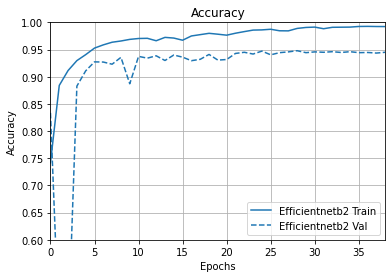

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "EfficientNetB2": history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.6,1])

(0.0, 1.0)

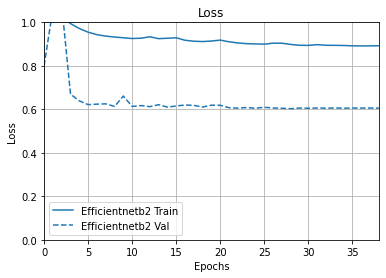

In [ ]:
plotter.plot({ "EfficientNetB2": history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

## Testing the metrics of the model loaded

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report  
from keras.preprocessing.image import ImageDataGenerator  
test_datagen=ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/data/test",
    target_size=(260, 260),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)



Found 1579 images belonging to 3 classes.


In [ ]:
 
y_pred=model.predict_classes(test_generator)

In [ ]:

print("Confusion matrix:\n"+ str(confusion_matrix(test_generator.labels,y_pred)))

# Calculate precision per class
from sklearn.metrics import precision_score
prec = precision_score( test_generator.labels, y_pred, average=None )

print( "Precision (Positive Predictive Value) per class =\n " + str( prec ))

# Calculate recall per class
from sklearn.metrics import recall_score

rec = recall_score( test_generator.labels, y_pred, average=None )

print( "Recall (Sensitiviy) per class =\n  " + str( rec ))
from sklearn.metrics import accuracy_score
print(" Accuracy="+str(accuracy_score(y_pred,test_generator.labels)))

Confusion matrix:
[[ 89   4   7]
 [  0 860  25]
 [  4  38 552]]
Precision (Positive Predictive Value) per class =
 [0.95698925 0.95343681 0.94520548]
Recall (Sensitiviy) per class =
  [0.89       0.97175141 0.92929293]
 Accuracy=0.9506016466117796
